# 1. Assume that we only want to use the input at time step $t'$ to predict the output at time step $t\gt t'$. What are the best values for the reset and update gates for each time step?

If we only want to use the input at time step $t'$ to predict the output at time step $t\gt t'$, then we want to preserve the hidden state $h_{t'}$ as much as possible and ignore the inputs at other time steps. Therefore, the best values for the reset and update gates are:

- For $k \lt t'$, we set $z_k=0$ and $r_k=0$. This means that we do not update the hidden state at all and we do not use the previous hidden state to compute the candidate hidden state. The hidden state remains as the initial value $h_0$ until time step $t'$.
- For $k = t'$, we set $z_{t'}=0$ and $r_{t'}=1$. This means that we do not update the hidden state with the candidate hidden state, but we use the previous hidden state $h_0$ to compute the candidate hidden state. The candidate hidden state becomes a function of the input at time step $t'$ and the initial value $h_0$. The hidden state remains as $h_{t'}=\frac{M^{t'}x_0}{\|M^{t'}x_0\|}$.
- For $k \gt t'$, we set $z_k=1$ and $r_k=0$. This means that we update the hidden state with the candidate hidden state, but we do not use the previous hidden state to compute the candidate hidden state. The candidate hidden state becomes a function of only the input at each time step. The hidden state becomes a weighted average of the candidate hidden state and the hidden state at time step $t'$. The hidden state remains close to $h_{t'}$ as long as the inputs are not too large.

This way, we can ensure that the hidden state at time step $t$ is mostly influenced by the input at time step $t'$ and not by other inputs.

- (1) 10.2. Gated Recurrent Units (GRU) — Dive into Deep .... https://d2l.ai/chapter_recurrent-modern/gru.html.
- (2) GRU unit: difference between Update and Forget gates. https://stats.stackexchange.com/questions/586668/gru-unit-difference-between-update-and-forget-gates.
- (3) Gated Recurrent Unit Networks - GeeksforGeeks. https://www.geeksforgeeks.org/gated-recurrent-unit-networks/.
- (4) Gated Recurrent Unit – What Is It And How To Learn .... https://analyticsindiamag.com/gated-recurrent-unit-what-is-it-and-how-to-learn/.
(5) GRU(Gated recurrent unit)结构介绍 - CSDN博客. https://blog.csdn.net/fangfanglovezhou/article/details/122560797.

# 2. Adjust the hyperparameters and analyze their influence on running time, perplexity, and the output sequence.

In [1]:
import sys
import torch.nn as nn
import torch
import warnings
sys.path.append('/home/jovyan/work/d2l_solutions/notebooks/exercises/d2l_utils/')
import d2l
from torchsummary import summary
warnings.filterwarnings("ignore")
from sklearn.model_selection import ParameterGrid

class GRU(d2l.RNN):
    def __init__(self, num_inputs, num_hiddens):
        d2l.Module.__init__(self)
        self.save_hyperparameters()
        self.rnn = nn.GRU(num_inputs, num_hiddens)
        
def stat_val(model, data):
    ppls = []
    for batch in iter(data.get_dataloader(False)):
        ppls.append(model.validation_step(batch, plot_flag=False).detach().numpy())
    return np.exp(np.mean(ppls))

def experient(data_class=d2l.TimeMachine, num_steps=32, num_hiddens=32, lr=1):
    data = data_class(batch_size=1024, num_steps=num_steps)
    gru = GRU(num_inputs=len(data.vocab), num_hiddens=num_hiddens)
    model = d2l.RNNLM(gru, vocab_size=len(data.vocab), lr=lr)
    trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1) #, num_gpus=1
    trainer.fit(model, data)
    return stat_val(model, data)

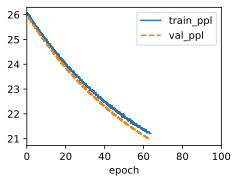

In [ ]:
param_grid = {'num_steps':[8, 16, 32, 64, 128],
              'num_hiddens':[8, 16, 32, 64, 128],
              'lr':[0.01,0.1,1,10]}
param_grid_obj = ParameterGrid(param_grid)
ppls = []
for params in param_grid_obj:
    ppl = experient(**params)
    ppls.append(ppl)
    print(params, ppl)

# 3. Compare runtime, perplexity, and the output strings for rnn.RNN and rnn.GRU implementations with each other.

# 4. What happens if you implement only parts of a GRU, e.g., with only a reset gate or only an update gate?

In [ ]:
class ResetGRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        # self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
        
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            # Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
            #                 torch.matmul(H, self.W_hz) + self.b_z)
            R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(R * H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            H = H_tilde
            outputs.append(H)
        return outputs, H
    
class UpdateGRUScratch(d2l.Module):
    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()

        init_weight = lambda *shape: nn.Parameter(torch.randn(*shape) * sigma)
        triple = lambda: (init_weight(num_inputs, num_hiddens),
                          init_weight(num_hiddens, num_hiddens),
                          nn.Parameter(torch.zeros(num_hiddens)))
        self.W_xz, self.W_hz, self.b_z = triple()  # Update gate
        # self.W_xr, self.W_hr, self.b_r = triple()  # Reset gate
        self.W_xh, self.W_hh, self.b_h = triple()  # Candidate hidden state
        
    def forward(self, inputs, H=None):
        if H is None:
            # Initial state with shape: (batch_size, num_hiddens)
            H = torch.zeros((inputs.shape[1], self.num_hiddens),
                          device=inputs.device)
        outputs = []
        for X in inputs:
            Z = torch.sigmoid(torch.matmul(X, self.W_xz) +
                            torch.matmul(H, self.W_hz) + self.b_z)
            # R = torch.sigmoid(torch.matmul(X, self.W_xr) +
                            # torch.matmul(H, self.W_hr) + self.b_r)
            H_tilde = torch.tanh(torch.matmul(X, self.W_xh) +
                               torch.matmul(H, self.W_hh) + self.b_h)
            H = Z * H + (1 - Z) * H_tilde
            H = H_tilde
            outputs.append(H)
        return outputs, H

In [ ]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
gru = GRUScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = d2l.RNNLMScratch(gru, vocab_size=len(data.vocab), lr=4)
trainer = d2l.Trainer(max_epochs=50, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)